In [6]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from typing import List, Dict, Union, Tuple, Optional
from pathlib import Path
import os
from tqdm import tqdm
import cv2

# Import the required modules (assuming they're available)
from nexar_arch import EnhancedFrameCNN
from nexar_videos import create_video_transforms


class VideoDataset(torch.utils.data.Dataset):
    """
    Simple dataset for inference that works with full video paths.
    """
    def __init__(self, video_paths: List[str], transform=None, num_frames: int = 50):
        self.video_paths = video_paths
        self.transform = transform
        self.num_frames = num_frames
        
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        
        # Load video frames
        frames = self._load_video_frames(video_path)
        
        # Convert to torch tensor and reshape to [C, T, H, W] for the transform
        frames = torch.from_numpy(frames)
        frames = frames.permute(3, 0, 1, 2)
        
        # Apply transform if available
        if self.transform:
            frames = self.transform(frames)
        else:
            # If no transform, just normalize to [0, 1]
            frames = frames.float() / 255.0
        
        # Convert back to [T, H, W, C] for compatibility with the training code
        frames = frames.permute(1, 2, 3, 0)
        
        return {
            'frames': frames,
            'video_path': video_path,
            'video_id': os.path.basename(video_path)
        }
    
    def _load_video_frames(self, video_path: str) -> np.ndarray:
        """Load frames from video file."""
        cap = cv2.VideoCapture(video_path)
        
        # Get total number of frames
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames < self.num_frames:
            # If video is shorter than required, repeat frames
            indices = np.arange(total_frames)
            indices = np.pad(indices, (0, self.num_frames - total_frames), mode='wrap')
        else:
            # Sample frames uniformly
            indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        
        frames = []
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            else:
                # If frame reading fails, use the last valid frame
                if frames:
                    frames.append(frames[-1])
                else:
                    # Create a black frame as fallback
                    frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
        
        cap.release()
        
        # Convert to numpy array
        frames = np.stack(frames, axis=0)  # [T, H, W, C]
        
        return frames


class NexarVideoInference:
    """
    A clean inference class for Nexar video classification models.
    Works with full video paths instead of assuming a specific directory structure.
    """
    
    def __init__(
        self,
        checkpoint_path: str,
        base_model: str = 'convnext_tiny',
        temporal_mode: str = 'gru',
        num_classes: int = 3,
        device: str = 'cuda',
        batch_size: int = 8,
        num_frames: int = 50,
        verbose: bool = True
    ):
        """
        Initialize the inference class.
        
        Args:
            checkpoint_path: Path to the model checkpoint (.pth file)
            base_model: Base model architecture (must match the trained model)
            temporal_mode: Temporal aggregation mode (must match the trained model)
            num_classes: Number of output classes
            device: Device to run inference on ('cuda' or 'cpu')
            batch_size: Batch size for inference
            num_frames: Number of frames to sample from each video
            verbose: Whether to print progress messages
        """
        self.checkpoint_path = checkpoint_path
        self.base_model = base_model
        self.temporal_mode = temporal_mode
        self.num_classes = num_classes
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.verbose = verbose
        
        # Class mapping
        self.class_map = {0: 'Normal', 1: 'Near Collision', 2: 'Collision'}
        self.reverse_class_map = {v: k for k, v in self.class_map.items()}
        
        # Load the model
        self.model = self._load_model()
        
        # Create transforms (same as validation transforms in training)
        self.transform = create_video_transforms(mode='val')
        
        if self.verbose:
            print(f"✓ Model loaded from: {checkpoint_path}")
            print(f"✓ Using device: {self.device}")
            print(f"✓ Architecture: {base_model} + {temporal_mode}")
            print(f"✓ Sampling {num_frames} frames per video")
    
    def _load_model(self) -> nn.Module:
        """Load the trained model from checkpoint."""
        # Create model architecture
        model = EnhancedFrameCNN(
            base_model=self.base_model,
            pretrained=False,  # We're loading trained weights
            dropout_rate=0.5,
            temporal_mode=self.temporal_mode
        )
        
        # Adapt output layer
        feature_dim = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(feature_dim, self.num_classes)
        
        # Load checkpoint
        if not os.path.exists(self.checkpoint_path):
            raise FileNotFoundError(f"Checkpoint not found: {self.checkpoint_path}")
        
        checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
        
        # Handle different checkpoint formats
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        else:
            state_dict = checkpoint
        
        # Remove 'module.' prefix if present (from DDP training)
        new_state_dict = {}
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            new_state_dict[name] = v
        
        model.load_state_dict(new_state_dict)
        model.to(self.device)
        model.eval()
        
        return model
    
    def _validate_video_paths(self, video_paths: List[str]) -> Tuple[List[str], List[str]]:
        """
        Validate which video paths exist and are readable.
        
        Args:
            video_paths: List of video file paths
            
        Returns:
            Tuple of (valid_paths, invalid_paths)
        """
        valid_paths = []
        invalid_paths = []
        
        for path in video_paths:
            if os.path.exists(path) and os.path.isfile(path):
                # Check if it's a video file
                if path.lower().endswith(('.mp4', '.avi', '.mov', '.mkv', '.webm')):
                    valid_paths.append(path)
                else:
                    invalid_paths.append(path)
            else:
                invalid_paths.append(path)
        
        return valid_paths, invalid_paths
    
    def predict_batch(self, batch: Dict[str, torch.Tensor]) -> Tuple[np.ndarray, np.ndarray, List[str]]:
        """
        Predict on a single batch.
        
        Args:
            batch: Batch dictionary from DataLoader
            
        Returns:
            Tuple of (predictions, probabilities, predicted_classes)
        """
        with torch.no_grad():
            # Get frames and move to device
            frames = batch['frames'].permute(0, 4, 1, 2, 3).float().to(self.device)
            
            # Forward pass
            logits = self.model(frames)
            
            # Get probabilities and predictions
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            
            # Convert to numpy
            preds_np = preds.cpu().numpy()
            probs_np = probs.cpu().numpy()
            
            # Map to class names
            pred_classes = [self.class_map[p] for p in preds_np]
            
        return preds_np, probs_np, pred_classes
    
    def predict(self, video_paths: Union[str, List[str]], return_probs: bool = True) -> Dict[str, Union[str, Dict]]:
        """
        Predict on a list of video paths.
        
        Args:
            video_paths: Single video path or list of video paths
            return_probs: Whether to return probability scores for each class
            
        Returns:
            Dictionary mapping video_path to prediction results:
            {
                'path/to/video.mp4': {
                    'prediction': 'Normal/Near Collision/Collision',
                    'confidence': float,
                    'probabilities': {
                        'Normal': float,
                        'Near Collision': float,
                        'Collision': float
                    }
                }
            }
        """
        # Ensure video_paths is a list
        if isinstance(video_paths, str):
            video_paths = [video_paths]
        
        if self.verbose:
            print(f"\nProcessing {len(video_paths)} videos...")
        
        # Validate video paths
        valid_paths, invalid_paths = self._validate_video_paths(video_paths)
        
        if invalid_paths and self.verbose:
            print(f"⚠️  Warning: {len(invalid_paths)} invalid video paths:")
            for path in invalid_paths[:5]:
                print(f"   - {path}")
            if len(invalid_paths) > 5:
                print(f"   ... and {len(invalid_paths) - 5} more")
        
        # Initialize results
        results = {}
        
        # Add invalid paths to results
        for path in invalid_paths:
            results[path] = {
                'prediction': 'Error',
                'confidence': 0.0,
                'error': 'Invalid video path or format'
            }
        
        if not valid_paths:
            return results
        
        # Create dataset
        dataset = VideoDataset(valid_paths, transform=self.transform, num_frames=self.num_frames)
        
        # Create DataLoader
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        # Run inference
        with tqdm(total=len(valid_paths), desc="Inference", disable=not self.verbose) as pbar:
            for batch_idx, batch in enumerate(dataloader):
                try:
                    # Get predictions
                    preds, probs, pred_classes = self.predict_batch(batch)
                    
                    # Get video paths from batch
                    batch_paths = batch['video_path']
                    
                    # Store results
                    for i, video_path in enumerate(batch_paths):
                        result = {
                            'prediction': pred_classes[i],
                            'confidence': float(probs[i].max()),
                            'filename': os.path.basename(video_path)
                        }
                        
                        if return_probs:
                            result['probabilities'] = {
                                'Normal': float(probs[i][0]),
                                'Near Collision': float(probs[i][1]),
                                'Collision': float(probs[i][2])
                            }
                        
                        results[video_path] = result
                        pbar.update(1)
                        
                except Exception as e:
                    # Handle batch processing errors
                    if self.verbose:
                        print(f"\n⚠️  Error processing batch: {e}")
                    
                    # Try to identify which videos failed
                    for video_path in batch['video_path']:
                        if video_path not in results:
                            results[video_path] = {
                                'prediction': 'Error',
                                'confidence': 0.0,
                                'error': f'Processing error: {str(e)}'
                            }
                    pbar.update(len(batch['video_path']))
        
        if self.verbose:
            successful = sum(1 for r in results.values() if r['prediction'] != 'Error')
            print(f"\n✓ Inference complete! Successfully processed {successful}/{len(video_paths)} videos")
        
        return results
    
    def predict_single(self, video_path: str) -> Dict[str, Union[str, float, Dict]]:
        """
        Convenience method to predict on a single video.
        
        Args:
            video_path: Path to video file
            
        Returns:
            Prediction result dictionary
        """
        results = self.predict([video_path])
        return results[video_path]
    
    def predict_from_csv(self, csv_path: str, path_column: str = 'video_path') -> pd.DataFrame:
        """
        Predict on videos listed in a CSV file.
        
        Args:
            csv_path: Path to CSV file containing video paths
            path_column: Column name containing video paths
            
        Returns:
            DataFrame with predictions added
        """
        # Load CSV
        df = pd.read_csv(csv_path)
        
        if path_column not in df.columns:
            raise ValueError(f"Column '{path_column}' not found in CSV")
        
        # Get video paths
        video_paths = df[path_column].tolist()
        
        # Run predictions
        results = self.predict(video_paths)
        
        # Add predictions to DataFrame
        df['predicted_class'] = df[path_column].map(lambda x: results.get(x, {}).get('prediction', 'Error'))
        df['confidence'] = df[path_column].map(lambda x: results.get(x, {}).get('confidence', 0.0))
        
        # Add individual class probabilities
        for class_name in ['Normal', 'Near Collision', 'Collision']:
            df[f'prob_{class_name.replace(" ", "_").lower()}'] = df[path_column].map(
                lambda x: results.get(x, {}).get('probabilities', {}).get(class_name, 0.0)
            )
        
        # Add error messages if any
        df['error'] = df[path_column].map(lambda x: results.get(x, {}).get('error', ''))
        
        return df
    
    def predict_directory(self, directory_path: str, extensions: List[str] = ['.mp4', '.avi', '.mov']) -> pd.DataFrame:
        """
        Predict on all videos in a directory.
        
        Args:
            directory_path: Path to directory containing videos
            extensions: List of video file extensions to process
            
        Returns:
            DataFrame with predictions for all videos
        """
        # Find all video files
        video_paths = []
        for ext in extensions:
            video_paths.extend(Path(directory_path).rglob(f'*{ext}'))
        
        # Convert to string paths
        video_paths = [str(p) for p in video_paths]
        
        if self.verbose:
            print(f"Found {len(video_paths)} videos in {directory_path}")
        
        # Run predictions
        results = self.predict(video_paths)
        
        # Create DataFrame
        data = []
        for path, result in results.items():
            row = {
                'video_path': path,
                'filename': os.path.basename(path),
                'predicted_class': result['prediction'],
                'confidence': result['confidence']
            }
            
            # Add probabilities if available
            if 'probabilities' in result:
                for class_name, prob in result['probabilities'].items():
                    row[f'prob_{class_name.replace(" ", "_").lower()}'] = prob
            
            # Add error if any
            if 'error' in result:
                row['error'] = result['error']
            
            data.append(row)
        
        return pd.DataFrame(data)
    
    def get_model_info(self) -> Dict[str, any]:
        """Get information about the loaded model."""
        checkpoint = torch.load(self.checkpoint_path, map_location='cpu')
        
        info = {
            'base_model': self.base_model,
            'temporal_mode': self.temporal_mode,
            'num_classes': self.num_classes,
            'checkpoint_path': self.checkpoint_path
        }
        
        # Add training metrics if available
        if 'val_loss' in checkpoint:
            info['val_loss'] = checkpoint['val_loss']
        if 'val_accuracy' in checkpoint:
            info['val_accuracy'] = checkpoint['val_accuracy']
        if 'epoch' in checkpoint:
            info['training_epochs'] = checkpoint['epoch']
        
        return info
    
    def save_predictions(self, results: Dict[str, Dict], output_path: str):
        """
        Save prediction results to CSV file.
        
        Args:
            results: Dictionary of prediction results
            output_path: Path to save CSV file
        """
        # Convert results to DataFrame
        data = []
        for path, result in results.items():
            row = {
                'video_path': path,
                'filename': os.path.basename(path),
                'predicted_class': result['prediction'],
                'confidence': result.get('confidence', 0.0)
            }
            
            # Add probabilities if available
            if 'probabilities' in result:
                for class_name, prob in result['probabilities'].items():
                    row[f'prob_{class_name.replace(" ", "_").lower()}'] = prob
            
            # Add error if any
            if 'error' in result:
                row['error'] = result['error']
            
            data.append(row)
        
        df = pd.DataFrame(data)
        df.to_csv(output_path, index=False)
        
        if self.verbose:
            print(f"✓ Predictions saved to: {output_path}")

In [7]:
inferencer = NexarVideoInference(
    checkpoint_path='model_results/convnext_tiny_gru_20250603_101008/best_model.pth',
    base_model='convnext_tiny',
    temporal_mode='gru',
    device='cuda'
)

Created convnext_tiny with gru temporal aggregation
Feature dimension: 768
✓ Model loaded from: model_results/convnext_tiny_gru_20250603_101008/best_model.pth
✓ Using device: cuda
✓ Architecture: convnext_tiny + gru
✓ Sampling 50 frames per video


In [20]:
df = pd.read_csv('nvidia_delivery_to_train_small.csv')
df_test = df.loc[df['split']=='test'].reset_index(drop=True)
df_test

,id,video_type,state,city,latitude,longitude,avg_speed,max_speed,course,timestamp_millis,...,g_min_y,g_max_y,g_std_y,g_amplitude_y,g_mean,g_median,g_min,g_max,g_std,g_amplitude
0,67ab584a3d2d11aae026a965ec3cd160,Collision,California,View Park-Windsor Hills,34.032658,-118.341610,5.558000,11.690000,211.188383,1668120340000,...,0.017464,2.619254,0.107257,2.601790,0.136195,0.124358,0.017464,2.619254,0.107257,2.601790
1,45aafe8569427047c35dd2acb348f365,Normal,Arizona,Guadalupe,33.378276,-111.925032,20.013431,20.849431,89.521411,1655842804000,...,0.039713,0.864456,0.131601,0.824743,0.262284,0.228853,0.039713,0.864456,0.131601,0.824743
2,35c5d97bff0e2365cab7944c0c5cc107,Normal,California,Mayflower Village,34.110783,-117.985823,16.123600,16.690000,113.597777,1625072318000,...,0.018303,0.713057,0.098802,0.694753,0.171922,0.149564,0.018303,0.713057,0.098802,0.694753
3,c03e70c8-e44a-412a-bf82-318de4796b6c,Near Collision,California,San Francisco,37.790809,-122.403721,4.072126,7.157426,80.689366,1625958424000,...,0.021801,0.775989,0.095327,0.754188,0.144242,0.110846,0.021801,0.775989,0.095327,0.754188
4,172870350b7b528d69f11dfff8c76e4c,Normal,Arizona,Queen Creek,33.249750,-111.637893,16.521711,19.174111,179.371948,1641661746000,...,0.008032,0.785273,0.122295,0.777241,0.103341,0.058129,0.008032,0.785273,0.122295,0.777241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,ba41e969a40de25b6e9c80dcb0fd3c9e,Near Collision,New York,Jamaica,40.703143,-73.813590,3.984600,6.809000,332.900636,1671144455000,...,0.017248,0.613060,0.079111,0.595813,0.126365,0.111917,0.017248,0.613060,0.079111,0.595813
131,1ee5320f14316a1d434e4791d830330e,Normal,California,Lawndale,33.894730,-118.368762,1.593700,3.468000,180.000000,1658257293000,...,0.034478,0.838117,0.072086,0.803639,0.128512,0.108023,0.034478,0.838117,0.072086,0.803639
132,8b70a3d1d66434d56f6871e1c31a22f7,Normal,New York,Jamaica,40.689629,-73.809410,14.616000,15.450000,156.696700,1671650130000,...,0.122348,0.641770,0.091989,0.519422,0.416269,0.423397,0.122348,0.641770,0.091989,0.519422
133,7ca7ccdb21dac6338c743b21a3f27c25,Near Collision,California,Lancaster,34.673670,-118.150194,0.397046,3.176046,270.604710,1670630059000,...,0.019240,0.700790,0.091036,0.681550,0.111769,0.090296,0.019240,0.700790,0.091036,0.681550


In [18]:
base_dirs=['../data/research-nvidia-data/nvidia-1', '../data/research-nvidia-data/nvidia-2']

In [21]:
import os
from pathlib import Path

def find_video_path(video_id, base_dirs):
    for base in base_dirs:
        video_dir = Path(base) / video_id
        if video_dir.exists() and video_dir.is_dir():
            for f in video_dir.iterdir():
                if f.suffix.lower() in [".mp4", ".mov"]:
                    return str(f.resolve())
    return None  # If not found

df_test['video_path'] = df_test['id'].apply(lambda vid: find_video_path(vid, base_dirs))
df_test

,id,video_type,state,city,latitude,longitude,avg_speed,max_speed,course,timestamp_millis,...,g_max_y,g_std_y,g_amplitude_y,g_mean,g_median,g_min,g_max,g_std,g_amplitude,video_path
0,67ab584a3d2d11aae026a965ec3cd160,Collision,California,View Park-Windsor Hills,34.032658,-118.341610,5.558000,11.690000,211.188383,1668120340000,...,2.619254,0.107257,2.601790,0.136195,0.124358,0.017464,2.619254,0.107257,2.601790,/home/ubuntu/data/research-nvidia-data/nvidia-...
1,45aafe8569427047c35dd2acb348f365,Normal,Arizona,Guadalupe,33.378276,-111.925032,20.013431,20.849431,89.521411,1655842804000,...,0.864456,0.131601,0.824743,0.262284,0.228853,0.039713,0.864456,0.131601,0.824743,/home/ubuntu/data/research-nvidia-data/nvidia-...
2,35c5d97bff0e2365cab7944c0c5cc107,Normal,California,Mayflower Village,34.110783,-117.985823,16.123600,16.690000,113.597777,1625072318000,...,0.713057,0.098802,0.694753,0.171922,0.149564,0.018303,0.713057,0.098802,0.694753,/home/ubuntu/data/research-nvidia-data/nvidia-...
3,c03e70c8-e44a-412a-bf82-318de4796b6c,Near Collision,California,San Francisco,37.790809,-122.403721,4.072126,7.157426,80.689366,1625958424000,...,0.775989,0.095327,0.754188,0.144242,0.110846,0.021801,0.775989,0.095327,0.754188,/home/ubuntu/data/research-nvidia-data/nvidia-...
4,172870350b7b528d69f11dfff8c76e4c,Normal,Arizona,Queen Creek,33.249750,-111.637893,16.521711,19.174111,179.371948,1641661746000,...,0.785273,0.122295,0.777241,0.103341,0.058129,0.008032,0.785273,0.122295,0.777241,/home/ubuntu/data/research-nvidia-data/nvidia-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,ba41e969a40de25b6e9c80dcb0fd3c9e,Near Collision,New York,Jamaica,40.703143,-73.813590,3.984600,6.809000,332.900636,1671144455000,...,0.613060,0.079111,0.595813,0.126365,0.111917,0.017248,0.613060,0.079111,0.595813,/home/ubuntu/data/research-nvidia-data/nvidia-...
131,1ee5320f14316a1d434e4791d830330e,Normal,California,Lawndale,33.894730,-118.368762,1.593700,3.468000,180.000000,1658257293000,...,0.838117,0.072086,0.803639,0.128512,0.108023,0.034478,0.838117,0.072086,0.803639,/home/ubuntu/data/research-nvidia-data/nvidia-...
132,8b70a3d1d66434d56f6871e1c31a22f7,Normal,New York,Jamaica,40.689629,-73.809410,14.616000,15.450000,156.696700,1671650130000,...,0.641770,0.091989,0.519422,0.416269,0.423397,0.122348,0.641770,0.091989,0.519422,/home/ubuntu/data/research-nvidia-data/nvidia-...
133,7ca7ccdb21dac6338c743b21a3f27c25,Near Collision,California,Lancaster,34.673670,-118.150194,0.397046,3.176046,270.604710,1670630059000,...,0.700790,0.091036,0.681550,0.111769,0.090296,0.019240,0.700790,0.091036,0.681550,/home/ubuntu/data/research-nvidia-data/nvidia-...


In [11]:
# Example 1: Predict on a single video with full path
result = inferencer.predict_single('incident-0-fb0292d2-83a2-4092-a93f-3a23e1878e11.mp4')
print(f"Prediction: {result['prediction']} (confidence: {result['confidence']:.2%})")


Processing 1 videos...


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


✓ Inference complete! Successfully processed 1/1 videos
Prediction: Collision (confidence: 97.35%)


In [ ]:
video_paths = df_test['video_path']
results = inferencer.predict(video_paths)

for path, result in results.items():
    print(f"{os.path.basename(path)}: {result['prediction']} ({result['confidence']:.2%})")

In [24]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df['video_path'] = results_df.index
results_df = results_df.reset_index(drop=True)

df_test = df_test.merge(results_df[['video_path', 'prediction', 'confidence']], on='video_path', how='left')

In [26]:
df_test[['id','video_type','prediction','confidence']]

,id,video_type,prediction,confidence
0,67ab584a3d2d11aae026a965ec3cd160,Collision,Near Collision,0.643429
1,45aafe8569427047c35dd2acb348f365,Normal,Normal,0.963077
2,35c5d97bff0e2365cab7944c0c5cc107,Normal,Normal,0.927935
3,c03e70c8-e44a-412a-bf82-318de4796b6c,Near Collision,Near Collision,0.932552
4,172870350b7b528d69f11dfff8c76e4c,Normal,Normal,0.970003
...,...,...,...,...
130,ba41e969a40de25b6e9c80dcb0fd3c9e,Near Collision,Near Collision,0.480050
131,1ee5320f14316a1d434e4791d830330e,Normal,Normal,0.931270
132,8b70a3d1d66434d56f6871e1c31a22f7,Normal,Normal,0.875648
133,7ca7ccdb21dac6338c743b21a3f27c25,Near Collision,Normal,0.819118


In [ ]:
import pandas as pd

results_df = pd.DataFrame([
    {"video_path": path, "prediction": r["prediction"], "confidence": r["confidence"]}
    for path, r in results.items()
])

df_test = df_test.merge(results_df, on="video_path", how="left")

CONFUSION MATRIX AND ACCURACY METRICS ANALYSIS

Dataset Overview:
Total samples: 135
Unique actual classes: 3
Unique predicted classes: 3

Actual class distribution:
  Normal: 81 (60.00%)
  Near Collision: 36 (26.67%)
  Collision: 18 (13.33%)

Predicted class distribution:
  Normal: 101 (74.81%)
  Near Collision: 24 (17.78%)
  Collision: 10 (7.41%)

Confusion Matrix:
                Collision  Near Collision  Normal
Collision               8               7       3
Near Collision          1              17      18
Normal                  1               0      80

Detailed Classification Report:
                precision    recall  f1-score   support

     Collision       0.80      0.44      0.57        18
Near Collision       0.71      0.47      0.57        36
        Normal       0.79      0.99      0.88        81

      accuracy                           0.78       135
     macro avg       0.77      0.63      0.67       135
  weighted avg       0.77      0.78      0.75       135


O

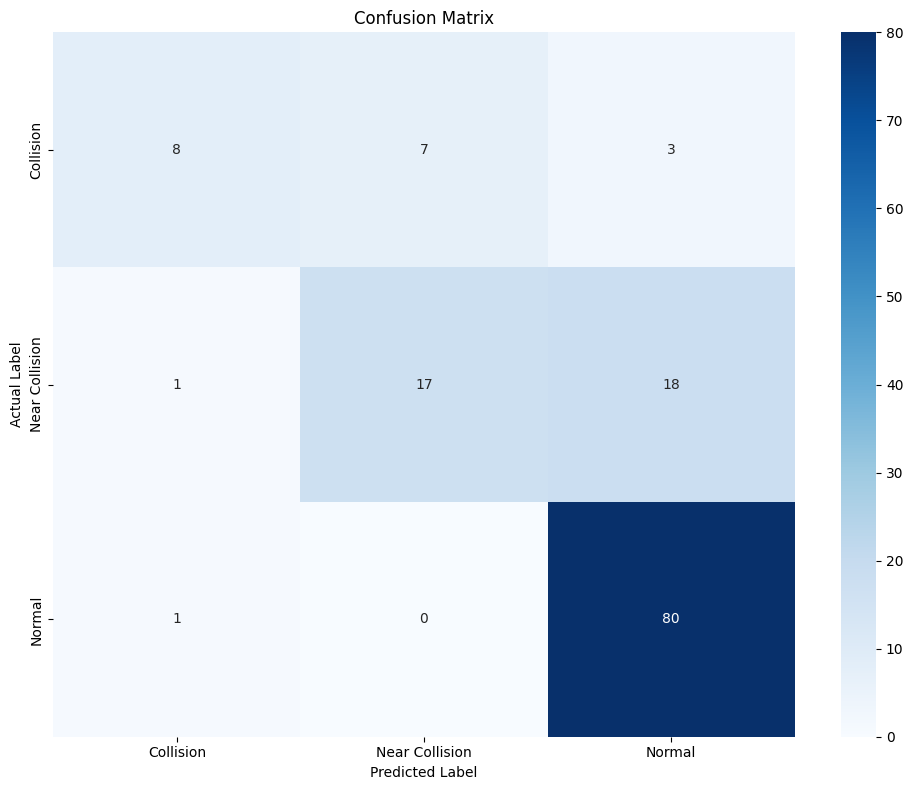

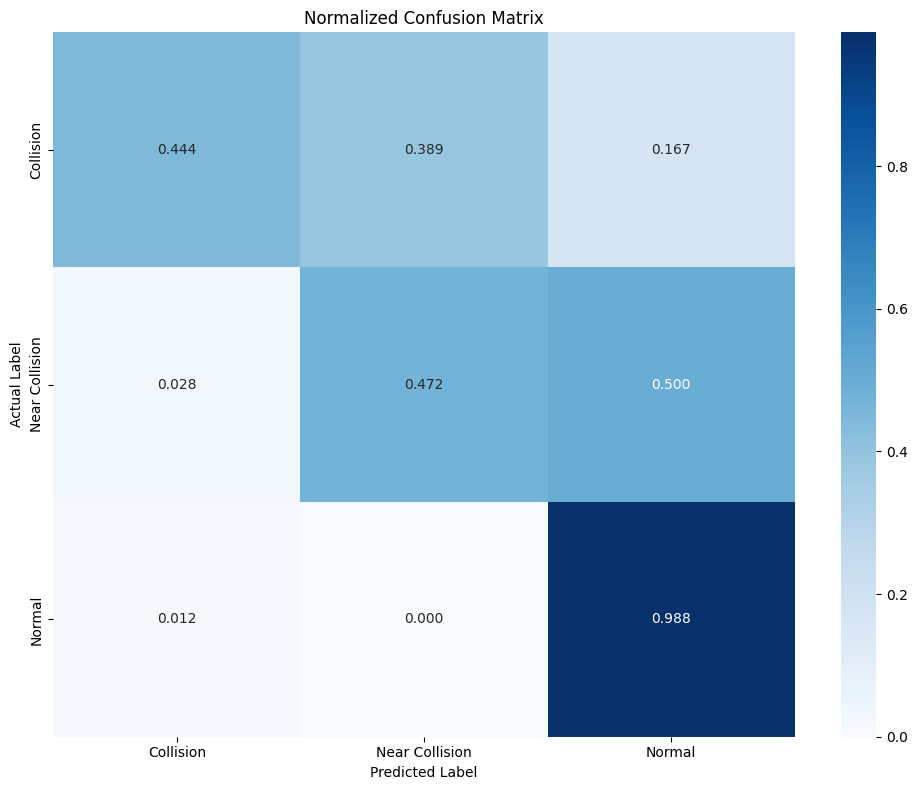

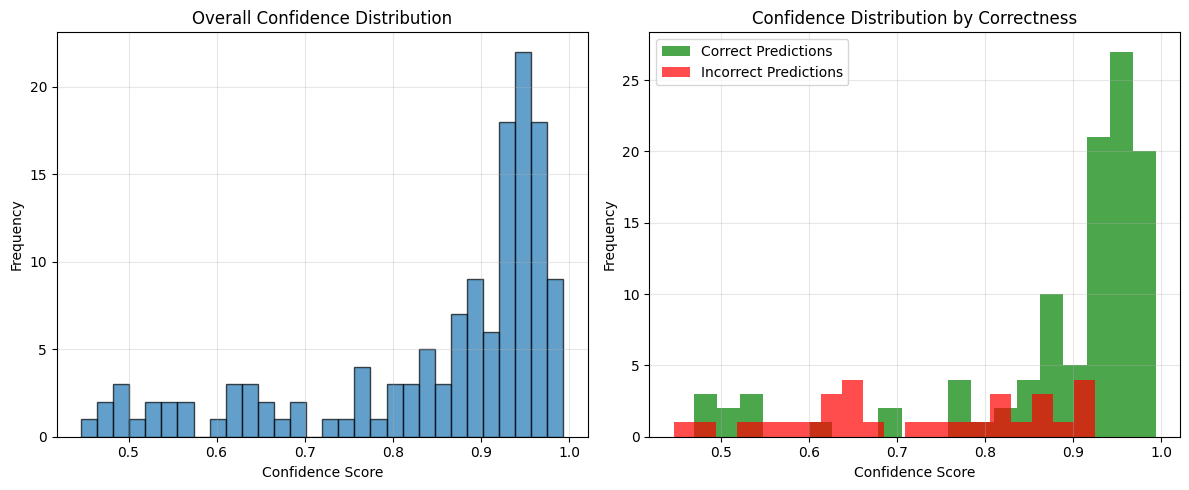


DETAILED ERROR ANALYSIS
Total misclassified samples: 30 (22.22%)

Error breakdown by actual class:
  Collision: 10/18 (55.56% error rate)
  Near Collision: 19/36 (52.78% error rate)
  Normal: 1/81 (1.23% error rate)

Most common misclassifications:
  Near Collision → Normal: 18 cases (60.00% of errors)
  Collision → Near Collision: 7 cases (23.33% of errors)
  Collision → Normal: 3 cases (10.00% of errors)
  Near Collision → Collision: 1 cases (3.33% of errors)
  Normal → Collision: 1 cases (3.33% of errors)

Confidence analysis for errors:
Average confidence for misclassified samples: 0.7274
Errors with confidence < 0.5: 2 (6.67% of errors)


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

def analyze_predictions(df, actual_col='video_type', predicted_col='prediction', confidence_col='confidence'):
    """
    Comprehensive function for prediction analysis
    
    Parameters:
    df: DataFrame with relevant columns
    actual_col: name of column with actual values
    predicted_col: name of column with predictions
    confidence_col: name of column with confidence scores
    """
    
    print("=" * 60)
    print("CONFUSION MATRIX AND ACCURACY METRICS ANALYSIS")
    print("=" * 60)
    
    # 1. Basic statistics
    print(f"\nDataset Overview:")
    print(f"Total samples: {len(df)}")
    print(f"Unique actual classes: {df[actual_col].nunique()}")
    print(f"Unique predicted classes: {df[predicted_col].nunique()}")
    
    # 2. Class distribution
    print(f"\nActual class distribution:")
    actual_dist = df[actual_col].value_counts()
    for class_name, count in actual_dist.items():
        percentage = (count / len(df)) * 100
        print(f"  {class_name}: {count} ({percentage:.2f}%)")
    
    print(f"\nPredicted class distribution:")
    pred_dist = df[predicted_col].value_counts()
    for class_name, count in pred_dist.items():
        percentage = (count / len(df)) * 100
        print(f"  {class_name}: {count} ({percentage:.2f}%)")
    
    # 3. Confusion Matrix
    y_true = df[actual_col]
    y_pred = df[predicted_col]
    
    cm = confusion_matrix(y_true, y_pred)
    classes = sorted(df[actual_col].unique())
    
    print(f"\nConfusion Matrix:")
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    print(cm_df)
    
    # 4. Classification Report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred))
    
    # 5. Overall Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # 6. Confidence statistics
    if confidence_col in df.columns:
        print(f"\nConfidence Score Statistics:")
        print(f"Mean confidence: {df[confidence_col].mean():.4f}")
        print(f"Median confidence: {df[confidence_col].median():.4f}")
        print(f"Min confidence: {df[confidence_col].min():.4f}")
        print(f"Max confidence: {df[confidence_col].max():.4f}")
        print(f"Std confidence: {df[confidence_col].std():.4f}")
        
        # Confidence by correctness
        df['correct'] = (df[actual_col] == df[predicted_col])
        correct_conf = df[df['correct']][confidence_col].mean()
        incorrect_conf = df[~df['correct']][confidence_col].mean()
        
        print(f"\nConfidence by prediction correctness:")
        print(f"Average confidence for correct predictions: {correct_conf:.4f}")
        print(f"Average confidence for incorrect predictions: {incorrect_conf:.4f}")
    
    return cm_df, classes

def plot_confusion_matrix(df, actual_col='video_type', predicted_col='prediction'):
    """
    Plot confusion matrix heatmap
    """
    y_true = df[actual_col]
    y_pred = df[predicted_col]
    
    cm = confusion_matrix(y_true, y_pred)
    classes = sorted(df[actual_col].unique())
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.tight_layout()
    plt.show()
    
    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.tight_layout()
    plt.show()

def plot_confidence_distribution(df, confidence_col='confidence'):
    """
    Plot confidence score distribution
    """
    plt.figure(figsize=(12, 5))
    
    # Overall confidence distribution
    plt.subplot(1, 2, 1)
    plt.hist(df[confidence_col], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Overall Confidence Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Confidence by correctness
    plt.subplot(1, 2, 2)
    df['correct'] = (df['video_type'] == df['prediction'])
    
    correct_conf = df[df['correct']][confidence_col]
    incorrect_conf = df[~df['correct']][confidence_col]
    
    plt.hist(correct_conf, bins=20, alpha=0.7, label='Correct Predictions', color='green')
    plt.hist(incorrect_conf, bins=20, alpha=0.7, label='Incorrect Predictions', color='red')
    plt.title('Confidence Distribution by Correctness')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def detailed_error_analysis(df, actual_col='video_type', predicted_col='prediction', confidence_col='confidence'):
    """
    Detailed analysis of prediction errors
    """
    print("\n" + "="*60)
    print("DETAILED ERROR ANALYSIS")
    print("="*60)
    
    # Identify misclassified samples
    errors = df[df[actual_col] != df[predicted_col]].copy()
    
    if len(errors) == 0:
        print("No prediction errors found!")
        return
    
    print(f"Total misclassified samples: {len(errors)} ({len(errors)/len(df)*100:.2f}%)")
    
    # Error breakdown by actual class
    print(f"\nError breakdown by actual class:")
    error_by_actual = errors.groupby(actual_col).size()
    total_by_actual = df.groupby(actual_col).size()
    
    for actual_class in error_by_actual.index:
        error_count = error_by_actual[actual_class]
        total_count = total_by_actual[actual_class]
        error_rate = (error_count / total_count) * 100
        print(f"  {actual_class}: {error_count}/{total_count} ({error_rate:.2f}% error rate)")
    
    # Most common misclassifications
    print(f"\nMost common misclassifications:")
    error_pairs = errors.groupby([actual_col, predicted_col]).size().sort_values(ascending=False)
    for (actual, predicted), count in error_pairs.head(10).items():
        percentage = (count / len(errors)) * 100
        print(f"  {actual} → {predicted}: {count} cases ({percentage:.2f}% of errors)")
    
    # Confidence analysis for errors
    if confidence_col in df.columns:
        print(f"\nConfidence analysis for errors:")
        avg_error_conf = errors[confidence_col].mean()
        print(f"Average confidence for misclassified samples: {avg_error_conf:.4f}")
        
        # Low confidence errors
        low_conf_threshold = 0.5
        low_conf_errors = errors[errors[confidence_col] < low_conf_threshold]
        print(f"Errors with confidence < {low_conf_threshold}: {len(low_conf_errors)} ({len(low_conf_errors)/len(errors)*100:.2f}% of errors)")

# Usage example:
# Assuming your DataFrame is called 'df' with columns: 'video_type', 'prediction', 'confidence'

# Run the analysis
cm_df, classes = analyze_predictions(df_test)

# Create visualizations
plot_confusion_matrix(df_test)
plot_confidence_distribution(df_test)

# Detailed error analysis
detailed_error_analysis(df_test)

In [ ]:
results = model.predict("path/to/video.mp4")
model.display_results(results, use_widget=True)

In [ ]:
video_paths = ["path/to/video1.mp4", "path/to/video2.mp4"]
batch_results = model.predict(video_paths)
model.display_results(batch_results)

In [ ]:
directory_results = model.predict("path/to/videos_directory")
model.display_results(directory_results)

In [5]:
import os
import pandas as pd

df_test = pd.read_csv('data_first_vision_model/test_data.csv')

video_extensions = (".mp4", ".mov")
base_dirs = ["../data/research-nvidia-data/nvidia-1", "../data/research-nvidia-data/nvidia-2"]

rows = []

for base_dir in base_dirs:
    for root, dirs, files in os.walk(base_dir):
        for d in dirs:
            subdir_path = os.path.join(root, d)
            for f in os.listdir(subdir_path):
                if f.lower().endswith(video_extensions):
                    video_path = os.path.abspath(os.path.join(subdir_path, f))
                    rows.append((d, video_path))
                    break

df = pd.DataFrame(rows, columns=["subdir", "video_path"])

test_list = df.loc[df['subdir'].isin(df_test.id)].drop_duplicates(subset='subdir')['video_path'].to_list()

len(test_list)

3791

In [8]:
%%time
batch_results = model.predict(
    test_list,
    batch_size=8,
    num_workers=1,
    verbose=True
)

Required package import error: No module named 'nexar_data'
Cannot run prediction without required packages.
Please ensure 'nexar_video_aug' and 'nexar_data' modules are available
CPU times: user 119 ms, sys: 615 ms, total: 733 ms
Wall time: 781 ms


In [7]:
# Ensure both IDs are strings
df_test['id'] = df_test['id'].astype(str)

# Normalize video_id from batch_results (remove extension)
for item in batch_results:

    item['video_id'] = os.path.basename(item['id'])

# Create DataFrame from predictions
df_pred = pd.DataFrame([
    {
        'video_id': item['video_id'],
        'predicted_class_name': item['predicted_class_name'],
        'probabilities': item['probabilities']
    }
    for item in batch_results
])

# Merge with ground truth
df_eval = pd.merge(df_pred, df_test[['id', 'video_type']], left_on='video_id', right_on='id', how='inner')

NameError: name 'batch_results' is not defined

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.gridspec as gridspec
import ast
import warnings
warnings.filterwarnings('ignore')

def evaluate_classification_model(df_eval):
    """
    Comprehensive evaluation function for video classification model with detailed visualizations
    """
    if df_eval.empty:
        print("Merged dataframe is empty. Check if video_id and id match.")
        return
    
    # Set plotting style and figure size
    plt.style.use('ggplot')
    sns.set(font_scale=1.2)
    
    # Extract true and predicted labels
    y_true = df_eval['video_type']
    y_pred = df_eval['predicted_class_name']
    
    # Convert probabilities from string to dictionary if needed
    if isinstance(df_eval['probabilities'].iloc[0], str):
        df_eval['probabilities'] = df_eval['probabilities'].apply(lambda x: ast.literal_eval(x))
    
    # Create binary classification columns
    df_eval['true_binary'] = df_eval['video_type'].apply(lambda x: 'Normal' if x == 'Normal' else 'Non-Normal')
    df_eval['pred_binary'] = df_eval['predicted_class_name'].apply(lambda x: 'Normal' if x == 'Normal' else 'Non-Normal')
    
    # Extract probability scores for each class
    df_eval['prob_normal'] = df_eval['probabilities'].apply(lambda x: x.get('Normal', 0))
    df_eval['prob_near_collision'] = df_eval['probabilities'].apply(lambda x: x.get('Near Collision', 0))
    df_eval['prob_collision'] = df_eval['probabilities'].apply(lambda x: x.get('Collision', 0))
    
    # Calculate metrics for each class
    classes = sorted(list(set(list(y_true) + list(y_pred))))
    
    # Create figure with subplots - adjusted layout
    fig = plt.figure(figsize=(20, 25))
    gs = gridspec.GridSpec(6, 2, figure=fig, height_ratios=[0.5, 1.5, 1.5, 1, 1, 1.5])
    
    # 1. Title and summary metrics
    ax_title = fig.add_subplot(gs[0, :])
    ax_title.axis('off')
    ax_title.text(0.5, 0.7, 'Video Classification Evaluation Dashboard', fontsize=24, ha='center', weight='bold')
    ax_title.text(0.5, 0.3, f'Total Samples: {len(df_eval)} | Classes: {", ".join(sorted(df_eval["video_type"].unique()))}', 
                 fontsize=16, ha='center')
    
    # 2. Detailed confusion matrix - square format
    ax_cm = fig.add_subplot(gs[1, 0])
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate row percentages (recall)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotation text with counts and percentages
    annot = np.empty_like(cm, dtype=object)
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax_cm,
                square=True, cbar=True)  # Square format
    ax_cm.set_title('Detailed Confusion Matrix\n(values show count and row %)', fontsize=16)
    ax_cm.set_xlabel('Predicted Label', fontsize=14)
    ax_cm.set_ylabel('True Label', fontsize=14)
    
    # 3. Class-specific metrics table
    ax_metrics_table = fig.add_subplot(gs[1, 1])
    
    # Calculate precision, recall, and F1 for each class
    class_metrics = {}
    for cls in classes:
        y_true_bin = np.array([1 if x == cls else 0 for x in y_true])
        y_pred_bin = np.array([1 if x == cls else 0 for x in y_pred])
        
        precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
        recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
        f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
        support = np.sum(y_true_bin)
        
        class_metrics[cls] = {
            'Precision': precision,
            'Recall': recall, 
            'F1-score': f1,
            'Support': support
        }
    
    # Add overall metrics
    cr = classification_report(y_true, y_pred, digits=3, output_dict=True)
    class_metrics['Macro Avg'] = {
        'Precision': cr['macro avg']['precision'],
        'Recall': cr['macro avg']['recall'],
        'F1-score': cr['macro avg']['f1-score'],
        'Support': len(y_true)
    }
    
    class_metrics['Weighted Avg'] = {
        'Precision': cr['weighted avg']['precision'],
        'Recall': cr['weighted avg']['recall'],
        'F1-score': cr['weighted avg']['f1-score'],
        'Support': len(y_true)
    }
    
    # Create DataFrame for metrics table
    metrics_df = pd.DataFrame(class_metrics).T
    
    # Display metrics as a table
    ax_metrics_table.axis('tight')
    ax_metrics_table.axis('off')
    table = ax_metrics_table.table(cellText=np.round(metrics_df.values, 3).astype(str),
                           colLabels=metrics_df.columns,
                           rowLabels=metrics_df.index,
                           cellLoc='center',
                           loc='center',
                           bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    
    for (row, col), cell in table.get_celld().items():
        if row == 0:  # Header row
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4472C4')
        elif col == 3:  # Support column
            cell.set_text_props(color='black')
            cell.set_facecolor('#E6E6E6')
        elif row > len(metrics_df) - 3:  # Average rows
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E6E6E6')
    
    ax_metrics_table.set_title('Performance Metrics by Class', fontsize=16)
    
    # 4. Binary confusion matrix (Normal vs Non-Normal) - square format
    ax_bin_cm = fig.add_subplot(gs[2, 0])
    cm_binary = confusion_matrix(df_eval['true_binary'], df_eval['pred_binary'])
    
    # Calculate row percentages for binary matrix
    bin_cm_percent = cm_binary.astype('float') / cm_binary.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotation text with counts and percentages
    bin_annot = np.empty_like(cm_binary, dtype=object)
    for i in range(len(cm_binary)):
        for j in range(len(cm_binary[i])):
            bin_annot[i, j] = f"{cm_binary[i, j]}\n({bin_cm_percent[i, j]:.1f}%)"
    
    sns.heatmap(cm_binary, annot=bin_annot, fmt='', cmap='Greens', 
                xticklabels=['Normal', 'Non-Normal'], yticklabels=['Normal', 'Non-Normal'], 
                ax=ax_bin_cm, square=True, cbar=True)  # Square format
    ax_bin_cm.set_title('Binary Confusion Matrix (Normal vs Rest)\n(values show count and row %)', fontsize=16)
    ax_bin_cm.set_xlabel('Predicted Label', fontsize=14)
    ax_bin_cm.set_ylabel('True Label', fontsize=14)
    
    # 5. Binary metrics table
    ax_bin_metrics = fig.add_subplot(gs[2, 1])
    
    # Calculate binary metrics
    binary_accuracy = accuracy_score(df_eval['true_binary'], df_eval['pred_binary'])
    binary_precision = precision_score(df_eval['true_binary'], df_eval['pred_binary'], pos_label='Non-Normal')
    binary_recall = recall_score(df_eval['true_binary'], df_eval['pred_binary'], pos_label='Non-Normal')
    binary_f1 = f1_score(df_eval['true_binary'], df_eval['pred_binary'], pos_label='Non-Normal')
    specificity = cm_binary[0, 0] / (cm_binary[0, 0] + cm_binary[0, 1])  # TN / (TN + FP)
    
    # Create binary metrics table
    binary_metrics = {
        'Normal vs Rest': {
            'Accuracy': binary_accuracy,
            'Precision': binary_precision,
            'Recall': binary_recall,
            'F1-score': binary_f1,
            'Specificity': specificity
        }
    }
    bin_metrics_df = pd.DataFrame(binary_metrics).T
    
    # Display binary metrics as a table
    ax_bin_metrics.axis('tight')
    ax_bin_metrics.axis('off')
    bin_table = ax_bin_metrics.table(cellText=np.round(bin_metrics_df.values, 3).astype(str),
                           colLabels=bin_metrics_df.columns,
                           rowLabels=bin_metrics_df.index,
                           cellLoc='center',
                           loc='center',
                           bbox=[0, 0, 1, 1])
    
    bin_table.auto_set_font_size(False)
    bin_table.set_fontsize(12)
    bin_table.scale(1, 1.5)
    
    for (row, col), cell in bin_table.get_celld().items():
        if row == 0:  # Header row
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4472C4')
    
    ax_bin_metrics.set_title('Binary Classification Metrics', fontsize=16)
    
    # 6. Probability distribution histograms for each class
    # Normal class histogram
    ax_normal_hist = fig.add_subplot(gs[3, 0])
    normal_samples = df_eval[df_eval['video_type'] == 'Normal']['prob_normal']
    not_normal_samples = df_eval[df_eval['video_type'] != 'Normal']['prob_normal']
    
    sns.histplot(normal_samples, bins=20, color='green', alpha=0.6, 
                 label='True Normal', ax=ax_normal_hist, stat='probability', kde=True)
    sns.histplot(not_normal_samples, bins=20, color='red', alpha=0.6, 
                 label='Not Normal', ax=ax_normal_hist, stat='probability', kde=True)
    
    ax_normal_hist.set_title('Normal Class Probability Distribution', fontsize=16)
    ax_normal_hist.set_xlabel('Model Probability for Normal Class', fontsize=14)
    ax_normal_hist.set_ylabel('Relative Frequency', fontsize=14)
    ax_normal_hist.legend()
    
    # Near Collision class histogram
    ax_near_collision_hist = fig.add_subplot(gs[3, 1])
    near_coll_samples = df_eval[df_eval['video_type'] == 'Near Collision']['prob_near_collision']
    not_near_coll_samples = df_eval[df_eval['video_type'] != 'Near Collision']['prob_near_collision']
    
    sns.histplot(near_coll_samples, bins=20, color='green', alpha=0.6, 
                 label='True Near Collision', ax=ax_near_collision_hist, stat='probability', kde=True)
    sns.histplot(not_near_coll_samples, bins=20, color='red', alpha=0.6, 
                 label='Not Near Collision', ax=ax_near_collision_hist, stat='probability', kde=True)
    
    ax_near_collision_hist.set_title('Near Collision Class Probability Distribution', fontsize=16)
    ax_near_collision_hist.set_xlabel('Model Probability for Near Collision Class', fontsize=14)
    ax_near_collision_hist.set_ylabel('Relative Frequency', fontsize=14)
    ax_near_collision_hist.legend()
    
    # Collision class histogram
    ax_collision_hist = fig.add_subplot(gs[4, 0])
    collision_samples = df_eval[df_eval['video_type'] == 'Collision']['prob_collision']
    not_collision_samples = df_eval[df_eval['video_type'] != 'Collision']['prob_collision']
    
    sns.histplot(collision_samples, bins=20, color='green', alpha=0.6, 
                 label='True Collision', ax=ax_collision_hist, stat='probability', kde=True)
    sns.histplot(not_collision_samples, bins=20, color='red', alpha=0.6, 
                 label='Not Collision', ax=ax_collision_hist, stat='probability', kde=True)
    
    ax_collision_hist.set_title('Collision Class Probability Distribution', fontsize=16)
    ax_collision_hist.set_xlabel('Model Probability for Collision Class', fontsize=14)
    ax_collision_hist.set_ylabel('Relative Frequency', fontsize=14)
    ax_collision_hist.legend()
    
    # Binary (Normal vs Non-Normal) probability histogram
    ax_binary_hist = fig.add_subplot(gs[4, 1])
    binary_normal_samples = df_eval[df_eval['true_binary'] == 'Normal']['prob_normal']
    binary_non_normal_samples = df_eval[df_eval['true_binary'] == 'Non-Normal']['prob_normal']
    
    sns.histplot(binary_normal_samples, bins=20, color='green', alpha=0.6, 
                 label='True Normal', ax=ax_binary_hist, stat='probability', kde=True)
    sns.histplot(binary_non_normal_samples, bins=20, color='red', alpha=0.6, 
                 label='True Non-Normal', ax=ax_binary_hist, stat='probability', kde=True)
    
    ax_binary_hist.set_title('Binary Classification Probability Distribution', fontsize=16)
    ax_binary_hist.set_xlabel('Model Probability for Normal Class', fontsize=14)
    ax_binary_hist.set_ylabel('Relative Frequency', fontsize=14)
    ax_binary_hist.legend()
    
    # 7. ROC curves for each class
    from sklearn.metrics import roc_curve, auc
    ax_roc = fig.add_subplot(gs[5, :])
    
    # Colors for ROC curves
    class_colors = {'Normal': 'blue', 'Near Collision': 'orange', 'Collision': 'red', 'Binary': 'green'}
    
    # Plot ROC curve for each class
    for cls in classes:
        y_true_bin = np.array([1 if x == cls else 0 for x in y_true])
        
        if cls == 'Normal':
            y_score = df_eval['prob_normal']
        elif cls == 'Near Collision':
            y_score = df_eval['prob_near_collision']
        elif cls == 'Collision':
            y_score = df_eval['prob_collision']
        
        fpr, tpr, _ = roc_curve(y_true_bin, y_score)
        roc_auc = auc(fpr, tpr)
        
        ax_roc.plot(fpr, tpr, lw=2, label=f'{cls} (AUC = {roc_auc:.3f})', color=class_colors[cls])
    
    # Plot binary ROC curve
    y_true_binary = np.array([1 if x == 'Non-Normal' else 0 for x in df_eval['true_binary']])
    y_score_binary = 1 - df_eval['prob_normal']  # Inverse of Normal probability for Non-Normal
    
    fpr_bin, tpr_bin, _ = roc_curve(y_true_binary, y_score_binary)
    roc_auc_bin = auc(fpr_bin, tpr_bin)
    
    ax_roc.plot(fpr_bin, tpr_bin, lw=2, label=f'Binary (AUC = {roc_auc_bin:.3f})', color=class_colors['Binary'], linestyle='--')
    
    # ROC plot styling
    ax_roc.plot([0, 1], [0, 1], 'k--', lw=1)
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate', fontsize=14)
    ax_roc.set_ylabel('True Positive Rate', fontsize=14)
    ax_roc.set_title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    ax_roc.legend(loc="lower right", fontsize=12)
    ax_roc.grid(True)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.show()
    
    # Print summary metrics
    print("\n=== Summary Statistics ===")
    print(f"Overall Accuracy: {cr['accuracy']:.3f}")
    print(f"Macro Avg F1-Score: {cr['macro avg']['f1-score']:.3f}")
    print(f"Weighted Avg F1-Score: {cr['weighted avg']['f1-score']:.3f}")
    
    print("\n=== Per-Class Metrics ===")
    for cls in classes:
        print(f"\n{cls}:")
        print(f"  Precision: {class_metrics[cls]['Precision']:.3f}")
        print(f"  Recall: {class_metrics[cls]['Recall']:.3f}")
        print(f"  F1-Score: {class_metrics[cls]['F1-score']:.3f}")
        print(f"  Support: {int(class_metrics[cls]['Support'])}")
    
    print("\n=== Binary Classification (Normal vs Non-Normal) ===")
    print(f"Binary Accuracy: {binary_accuracy:.3f}")
    print(f"Binary Precision: {binary_precision:.3f}")
    print(f"Binary Recall: {binary_recall:.3f}")
    print(f"Binary F1-Score: {binary_f1:.3f}")
    print(f"Binary Specificity: {specificity:.3f}")

# Call the function with your dataframe
evaluate_classification_model(df_eval)

NameError: name 'df_eval' is not defined

In [ ]:
df_eval.loc[(df_eval['video_type']=='Normal') & (df_eval['predicted_class_name']=='Collision')]

In [ ]:
df.loc[df['subdir']=='83180e784a8b81e2c220f3f99605bb12']['video_path'].iloc[0]

In [130]:
import shutil

src = '/home/ubuntu/data/research-nvidia-data/nvidia-2/83180e784a8b81e2c220f3f99605bb12/83180e784a8b81e2c220f3f99605bb12.mp4'
dst = './83180e784a8b81e2c220f3f99605bb12.mp4'

shutil.copy(src, dst)


'./83180e784a8b81e2c220f3f99605bb12.mp4'